# Handwritten Digit Classification with Hybrid CNN and SVM model
A comparative study of a classic CNN model and a CNN-SVM hybrid where the feature matrix learnt by a CNN's convolutional layers are used to train a multi-class SVM classifier.

In [23]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from math import isqrt

from matplotlib.colors import ListedColormap

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import learning_curve
from sklearn.svm import SVC

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical



In [2]:
tf.device('/GPU:0') if tf.config.list_physical_devices('GPU') else tf.device('/CPU:0')


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-12-07 00:59:15.203491: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-07 00:59:15.203793: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


------------------------------------------------------------------------

### Helper functions

In [3]:
# k-fold cross-validation
def k_fold_cross_validation(X, y, n_splits, model, epochs, batch_size):
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    scores = {'accuracy': [], 'loss': [], 'val_accuracy': [], 'val_loss': []}

    for train_index, test_index in cv.split(X):
        fold_no = len(scores['accuracy']) + 1

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        history = model.fit(X_train, y_train, epochs=epochs,
                            batch_size=batch_size, verbose=1, validation_split=0.2)

        score = model.evaluate(X_test, y_test, verbose=0)

        print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {score[0]}; {model.metrics_names[1]} of {score[1]*100}%')

        scores['accuracy'].append(score[1] * 100)
        scores['loss'].append(score[0])
        scores['val_accuracy'].append(history.history['val_accuracy'][-1] * 100)
        scores['val_loss'].append(history.history['val_loss'][-1])

    return scores

In [4]:
def pretty_print_cv_results(scores):
    print('------------------------------------------------------------------------')
    print('Score per fold')

    for i in range(len(scores['loss'])):
        print('------------------------------------------------------------------------')
        print(
            f"> Fold {i+1} - Loss: {scores['loss'][i]} - Accuracy: {scores['accuracy'][i]}%")

    print('------------------------------------------------------------------------')
    print('Average scores for all folds:')
    print(f"> Accuracy: {np.mean(scores['accuracy'])} (+- {np.std(scores['accuracy'])}")
    print(f"> Loss: {np.mean(scores['loss'])}")
    print('------------------------------------------------------------------------')


In [38]:
# plotting helpers

def plot_loss_accuracy(scores):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(scores['accuracy'], label='Accuracy')
    plt.plot(scores['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy and Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy / Val Accuracy')
    plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    plt.plot(scores['loss'], label='Loss')
    plt.plot(scores['val_loss'], label='Val Loss')
    plt.title('Loss and Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss / Val Loss')
    plt.legend(loc='best')

    plt.tight_layout()
    plt.show()


def plot_misclassified(X_test, y_test, y_pred):
    misclassified = np.where(y_test != y_pred)[0]
    print(f'Total misclassified samples: {len(misclassified)}')

    plt.figure(figsize=(10, 5))
    for i, index in enumerate(misclassified[:5]):
        plt.subplot(1, 5, i + 1)
        plt.imshow(X_test[index].reshape(28, 28), cmap='gray')
        plt.title(f'Predicted: {y_pred[index]}, Actual: {y_test[index]}')

    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


------------------------------------------------------------------------

### Loading and visualizing the dataset

In [6]:
# load the dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train.shape, y_train.shape, X_test.shape, y_test.shape


((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

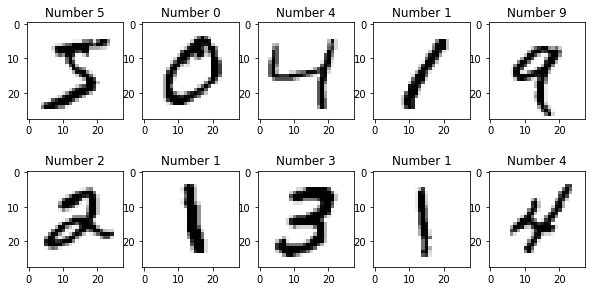

In [7]:
# plot the first few images
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i], cmap='binary')
    ax.set(title = f'Number {y_train[i]}')

plt.show()

### Preprocessing the dataset

In [8]:
# reshape the data to preserve only the alpha channel
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# one-hot encode the labels
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# convert int to float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalize the data
X_train /= 255
X_test /= 255


------------------------------------------------------------------------

### Building the baseline CNN model

In [9]:
# create the base model
base_model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
    ])


In [10]:
# add the dense layers (default classifier)
cnn = Sequential([
        base_model,
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])


In [11]:
# compile the model
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
cnn.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


### Training the baseline model

In [12]:
# train the model
scores = k_fold_cross_validation(X_train, y_train, 5, cnn, 10, 128)


Epoch 1/10


2022-12-07 00:59:16.918585: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-07 00:59:17.364706: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


297/300 [============================>.] - ETA: 0s - loss: 0.3614 - accuracy: 0.8865

2022-12-07 00:59:22.103564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


300/300 [==============================] - 6s 17ms/step - loss: 0.3592 - accuracy: 0.8871 - val_loss: 0.0912 - val_accuracy: 0.9725
Epoch 2/10
300/300 [==============================] - 6s 19ms/step - loss: 0.0956 - accuracy: 0.9712 - val_loss: 0.0574 - val_accuracy: 0.9819
Epoch 3/10
300/300 [==============================] - 5s 17ms/step - loss: 0.0627 - accuracy: 0.9821 - val_loss: 0.0475 - val_accuracy: 0.9852
Epoch 4/10
300/300 [==============================] - 6s 18ms/step - loss: 0.0489 - accuracy: 0.9854 - val_loss: 0.0488 - val_accuracy: 0.9854
Epoch 5/10
300/300 [==============================] - 5s 16ms/step - loss: 0.0368 - accuracy: 0.9888 - val_loss: 0.0469 - val_accuracy: 0.9866
Epoch 6/10
300/300 [==============================] - 5s 17ms/step - loss: 0.0281 - accuracy: 0.9911 - val_loss: 0.0362 - val_accuracy: 0.9897
Epoch 7/10
300/300 [==============================] - 5s 15ms/step - loss: 0.0242 - accuracy: 0.9925 - val_loss: 0.0460 - val_accuracy: 0.9889
Epoch 8/10

2022-12-07 01:00:09.180877: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Score for fold 1: loss of 0.04078652709722519; accuracy of 98.94166588783264%
Epoch 1/10
300/300 [==============================] - 5s 17ms/step - loss: 0.0206 - accuracy: 0.9940 - val_loss: 0.0403 - val_accuracy: 0.9905
Epoch 2/10
300/300 [==============================] - 6s 18ms/step - loss: 0.0156 - accuracy: 0.9949 - val_loss: 0.0411 - val_accuracy: 0.9892
Epoch 3/10
300/300 [==============================] - 6s 19ms/step - loss: 0.0116 - accuracy: 0.9965 - val_loss: 0.0483 - val_accuracy: 0.9892
Epoch 4/10
300/300 [==============================] - 6s 21ms/step - loss: 0.0087 - accuracy: 0.9968 - val_loss: 0.0489 - val_accuracy: 0.9894
Epoch 5/10
300/300 [==============================] - 5s 17ms/step - loss: 0.0072 - accuracy: 0.9975 - val_loss: 0.0475 - val_accuracy: 0.9897
Epoch 6/10
300/300 [==============================] - 5s 15ms/step - loss: 0.0069 - accuracy: 0.9977 - val_loss: 0.0554 - val_accuracy: 0.9885
Epoch 7/10
300/300 [==============================] - 4s 15ms/st

### Evaluating the baseline model

In [13]:
# cross-validation scores
pretty_print_cv_results(scores)


------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.04078652709722519 - Accuracy: 98.94166588783264%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.021448198705911636 - Accuracy: 99.48333501815796%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.025967076420783997 - Accuracy: 99.40000176429749%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.016913576051592827 - Accuracy: 99.6666669845581%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.013253380544483662 - Accuracy: 99.6999979019165%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 99.43833351135254 (+- 0.272315117088744
> Loss: 0.02367375176399946
----------------------

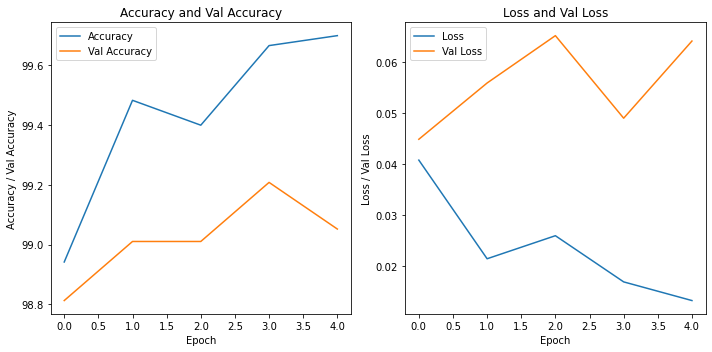

In [14]:
# loss and accuracy plots
plot_loss_accuracy(scores)

In [15]:
# save the model
cnn.save('./model/cnn_baseline.h5')


In [16]:
# load the model
cnn = load_model('./model/cnn_baseline.h5')

 55/313 [====>.........................] - ETA: 0s

2022-12-07 01:03:44.267187: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 3ms/step
Total misclassified samples: 94


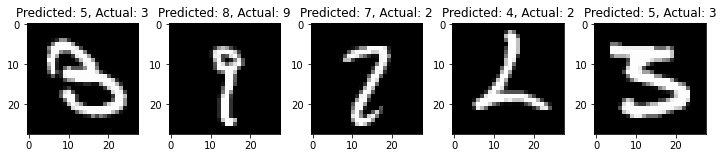

In [17]:
# plot the images that were misclassified

# get the predictions
y_pred = cnn.predict(X_test).argmax(axis=1)

# plot the images
plot_misclassified(X_test, y_test.argmax(axis=1), y_pred)


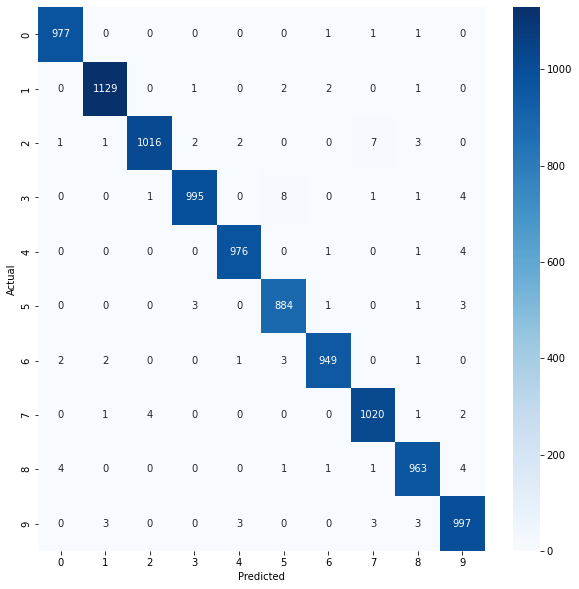

In [18]:
# plot the confusion matrix
plot_confusion_matrix(y_test.argmax(axis=1), y_pred)

---------------------------------------------------------------------------

### Building the hybrid CNN-SVM model

In [19]:
# extract features using base_model
X_train_features = base_model.predict(X_train)
X_test_features = base_model.predict(X_test)

X_train_features.shape, X_test_features.shape


  64/1875 [>.............................] - ETA: 4s

2022-12-07 01:03:45.939181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 29/313 [=>............................] - ETA: 1s

2022-12-07 01:03:51.027432: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 3ms/step


((60000, 1600), (10000, 1600))

In [41]:
# build the SVM classifier on top of the extracted features
svm = SVC(kernel='linear', C=1.0, random_state=42, verbose=False)


### Training the hybrid model

In [44]:
# train the model
svm.fit(X_train_features, y_train.argmax(axis=1))

train_sizes, train_scores, test_scores = learning_curve(svm, X_train_features, y_train.argmax(
    axis=1), cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1, verbose=0)


### Evaluating the hybrid model

In [45]:
# evaluate the model
y_pred = svm.predict(X_test_features)
y_test_labels = y_test.argmax(axis=1)

print(f'Accuracy: {accuracy_score(y_test_labels, y_pred) * 100}%')
print(classification_report(y_test_labels, y_pred))


Accuracy: 99.19%
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       0.99      1.00      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      1.00      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [46]:
# save the hybrid model
joblib.dump(svm, './model/cnn_svm.pkl')

['./model/cnn_svm.pkl']

In [47]:
# load the saved model
svm = joblib.load('./model/cnn_svm.pkl')

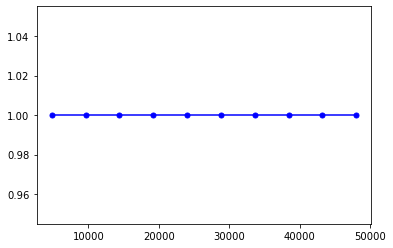

In [48]:
# plot accuracy vs number of training samples

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')

Total misclassified samples: 81


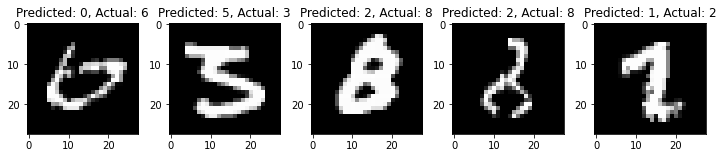

In [49]:
# plot misclassified images
plot_misclassified(X_test, y_test.argmax(axis=1), y_pred)

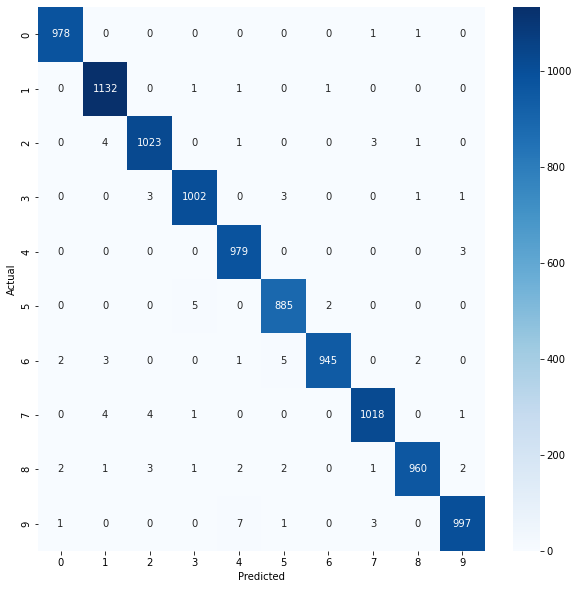

In [50]:
# plot the confusion matrix
plot_confusion_matrix(y_test.argmax(axis=1), y_pred)

------------------------------------------------------------------------

## Observations:
  - The hybrid model gives a slightly lower accuracy, but the number of misclassified digits is significantly lower (94 vs 81).